In [1]:
import requests
import pandas as pd
from bs4 import BeautifulSoup
import os
import json
import requests
import numpy as np
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import string
import mapclassify
from shapely.ops import unary_union
plt.style.use('ggplot')


### Open data same as before

In [52]:
def keep_relevant_set_index(df, relevant_columns):
    """
    Filters the DataFrame to include only the specified columns and sets 1st col as index
    
    Parameters:
    - df: The input DataFrame.
    - relevant_columns: List of column names to keep in the DataFrame.
    
    Returns:
    - A new DataFrame with only the specified columns.
    """
    filtered_df = df[relevant_columns] if all(col in df.columns for col in relevant_columns) else None
    
    if filtered_df is None:
        raise ValueError("One or more columns in 'relevant_columns' do not exist in the DataFrame.")
    filtered_df = filtered_df.set_index(filtered_df.columns[0])
    filtered_df = filtered_df.to_crs(epsg=3857) #convert to uniform epsg for all df

    return filtered_df

In [15]:
def simplify_column(df: pd.DataFrame, column_name: str, mapping_dict: dict):
    """
    Simplifies the values in a specific column based on a mapping dictionary.
    
    Parameters:
    - df: The input DataFrame.
    - column_name: The column to be simplified.
    - mapping_dict: A dictionary where the keys are the current values, 
      and the values are the simplified labels to map to.
    
    Returns:
    - A new DataFrame with the simplified column.
    """
    # Apply the mapping to the column
    df[column_name] = df[column_name].map(mapping_dict).fillna(df[column_name])

    return df

In [105]:
zones_geodata = gpd.read_file('CME538_Daniel_Group_Zoning Area - 4326.geojson')

zones_geodata = keep_relevant_set_index(zones_geodata, ["_id" , "GEN_ZONE", "geometry"])

zones_geodata.rename(columns={'GEN_ZONE': 'Zone_type'}, inplace=True)

# Define simplified mapping for Zone Type values
zone_mapping = {0: 'Residential', 1: 'Open Space', 2: 'Utility and Transportation', 
                4: 'Industrial', 5: 'Institutional',
                6: 'Commercial', 101: 'Residential', 
                201: 'Commercial', 202: 'Commercial'}

# Replace the values in 'Zone_type' column with the mapped names
zones_geodata['Zone_type'] = zones_geodata['Zone_type'].replace(zone_mapping)

# Display the first few rows to ensure it worked
zones_geodata.head()

,Zone_type,geometry
_id,,
1,Utility and Transportation,"MULTIPOLYGON (((-8817582.931 5437211.157, -881..."
2,Open Space,"MULTIPOLYGON (((-8850203.447 5420635.486, -885..."
3,Residential,"MULTIPOLYGON (((-8824777.541 5434648.934, -882..."
4,Open Space,"MULTIPOLYGON (((-8857736.121 5422483.393, -885..."
5,Residential,"MULTIPOLYGON (((-8823408.202 5436387.536, -882..."


In [5]:
zones_geodata.Zone_type.unique()

array(['Utility and Transportation', 'Open Space', 'Residential',
       'Industrial', 'Commercial', 'Institutional'], dtype=object)

### Plotting zones to compare

In [17]:
def plot_specific_subset(df, name, column, figsize=(10, 8), cmap='Set3'):
    """
    Plots a specific area/subset of data from the GeoDataFrame based on the specified name in col.
    
    Parameters:
    - df: GeoDataFrame containing the data.
    - name: The name or identifier of the area to plot.
    - column: The column used for categorical coloring (default is 'Zone_type').
    - figsize: Size of the plot (default is (10, 8)).
    - cmap: The colormap used for the plot (default is 'Set3').
    
    Returns:
    - Displays a plot of the specified zone.
    """
    # Filter the GeoDataFrame to only include the specified zone
    df = df[df[column] == name]

    # Check if the zone exists in the data
    if df.empty:
        print(f"Area '{name}' not found in the data.")
        return

    # Plotting the specific zone
    fig, ax = plt.subplots(figsize=figsize)

    # Plot with categorical coloring based on 'column' (default is 'Zone_type')
    df.plot(column=column, ax=ax, legend=True, 
                   legend_kwds={'bbox_to_anchor': (1, 1), 'loc': 'upper left'}, 
                   cmap=cmap, edgecolor='black')

    # Add labels and title
    plt.xlabel('Longitude', fontsize=12)
    plt.ylabel('Latitude', fontsize=12)
    plt.title(f'{name} Areas', fontsize=16)

    # Display the plot
    plt.show()

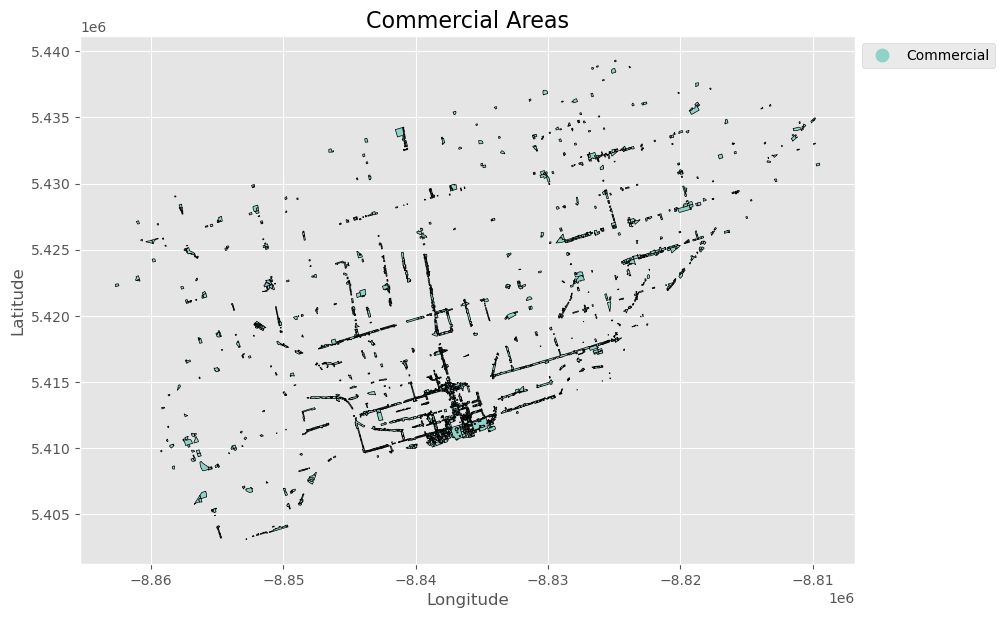

In [132]:
# Let's plot what area is open space
plot_specific_subset(zones_geodata, 'Commercial', 'Zone_type')


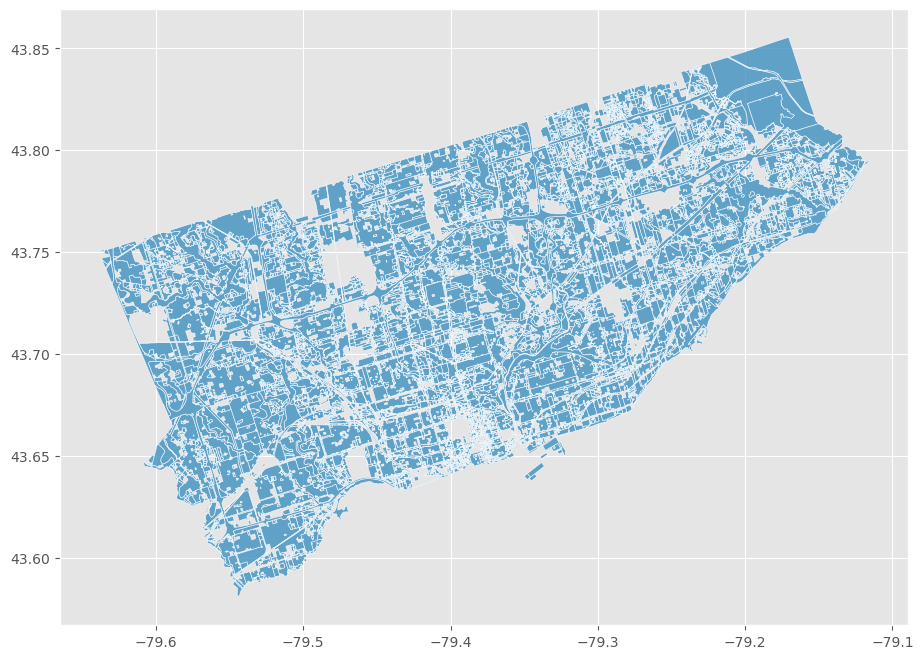

In [33]:
# Plotting all zones
zones_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

### Let's compare this with Greenspace dataset

In [117]:
greenspace = gpd.read_file('Green Spaces - 4326.geojson')

greenspace = keep_relevant_set_index(greenspace, ["_id" ,'AREA_CLASS', 'geometry'])
greenspace.rename(columns={'AREA_CLASS': 'Area_type'}, inplace=True)
greenspace.head()

,Area_type,geometry
_id,,
1,OTHER_CEMETERY,"MULTIPOLYGON (((-8822906.503 5439098.931, -882..."
2,OTHER_CEMETERY,"MULTIPOLYGON (((-8815348.558 5438381.216, -881..."
3,OTHER_CEMETERY,"MULTIPOLYGON (((-8832932.363 5435793.706, -883..."
4,OTHER_CEMETERY,"MULTIPOLYGON (((-8829678.227 5434392.983, -882..."
5,OTHER_CEMETERY,"MULTIPOLYGON (((-8829470.974 5433988.826, -882..."


In [118]:
greenspace.Area_type.unique() #let's check the type of green spaces

array(['OTHER_CEMETERY', 'OTHER_CITY', 'OTHER_GOLFCOURSE',
       'OTHER_PROVINCIAL_FEDERAL', 'OTHER_HYDRO', 'OTHER_ROAD',
       'OTHER_TRCA', 'OTHER_UNKNOWN', 'Building Grounds', 'Park',
       'Open Green Space', 'Traffic Island', 'Golf Course', 'Cul de Sac',
       'Hydro Field/Utility Corridor', 'Orphaned Space',
       'Civic Centre Square', 'Boulevard', 'Cemetery'], dtype=object)

In [119]:
# Let's simplify the types of "Green space"
greenspace_mapping = {                   
    'OTHER_CEMETERY': 'Cemetery',
    'OTHER_CITY': 'Other',
    'OTHER_GOLFCOURSE': 'Golf course',
    'OTHER_PROVINCIAL_FEDERAL': 'Other',
    'OTHER_HYDRO': 'Utilities and Transportation',
    'OTHER_ROAD': 'Utilities and Transportation', 
    'OTHER_TRCA': 'Greenspace',
    'OTHER_UNKNOWN': 'Other',
    'Building Grounds': 'Other',
    'Park': 'Greenspace',
    'Open Green Space': 'Greenspace',
    'Traffic Island': 'Utilities and Transportation',
    'Golf Course': 'Golf course',
    'Cul de Sac': 'Utilities and Transportation',
    'Hydro Field/Utility Corridor': 'Utilities and Transportation',
    'Orphaned Space': 'Other', 
    'Civic Centre Square': 'Other',
    'Boulevard': 'Utilities and Transportation',
    'Cemetery': 'Cemetery'
}

# Replace the values in 'Zone_type' column with the mapped names
greenspace['Area_type'] = greenspace['Area_type'].replace(greenspace_mapping)

# Display the first few rows to ensure it worked
greenspace.head()

,Area_type,geometry
_id,,
1,Cemetery,"MULTIPOLYGON (((-8822906.503 5439098.931, -882..."
2,Cemetery,"MULTIPOLYGON (((-8815348.558 5438381.216, -881..."
3,Cemetery,"MULTIPOLYGON (((-8832932.363 5435793.706, -883..."
4,Cemetery,"MULTIPOLYGON (((-8829678.227 5434392.983, -882..."
5,Cemetery,"MULTIPOLYGON (((-8829470.974 5433988.826, -882..."


In [120]:
# Check new simplified types
greenspace.Area_type.unique()

array(['Cemetery', 'Other', 'Golf course', 'Utilities and Transportation',
       'Greenspace'], dtype=object)

### Create aggregated greenspace df

In [121]:
aggregated_greenspace = greenspace.groupby('Area_type')['geometry'].apply(lambda x: x.unary_union).reset_index()

# Calculate are in square km, because crs is EPSG 3857, standard area calc will be in m^2
aggregated_greenspace['Area'] = aggregated_greenspace.geometry.area/(1000**2)

# Now 'aggregated_zones' will contain the union of polygons for each 'Zone_type' with the total area
aggregated_greenspace

,Area_type,geometry,Area
0,Cemetery,"MULTIPOLYGON (((-8849738.999 5406369.433, -884...",9.464416
1,Golf course,"MULTIPOLYGON (((-8857665.581 5408486.096, -885...",17.918173
2,Greenspace,"MULTIPOLYGON (((-8856211.485 5404435.903, -885...",162.640948
3,Other,"MULTIPOLYGON (((-8855139.808 5402243.758, -885...",24.294922
4,Utilities and Transportation,"MULTIPOLYGON (((-8857116.113 5404857.742, -885...",17.902800


In [122]:
# # Let's merge the true green space with the zone "Open space" to see total area
# merged_greenspace = gpd.overlay(greenspace[greenspace['Area_type'] == 'Greenspace'], 
#                                 zones_geodata[zones_geodata['Zone_type'] == 'Open Space'], how='union')

# merged_greenspace.plot(figsize=(15, 8), edgecolor='b', alpha=0.75);

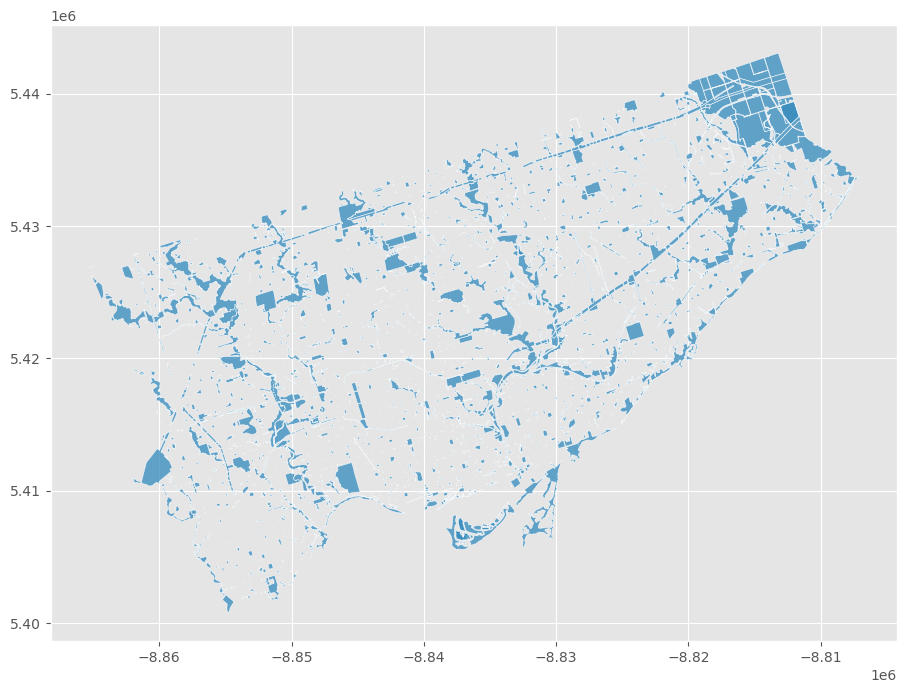

In [130]:
aggregated_greenspace.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

### Let's bring in flooding data

In [39]:
flood_plains = gpd.read_file('Floodline GeoJson Format.geojson')
flood_plains = flood_plains.set_index(flood_plains.columns[0])
flood_plains = flood_plains.to_crs(epsg=3857)
flood_plains.head()

,FloodPlain,Watershed,Shape__Are,Shape__Len,geometry
OBJECTID,,,,,
3394,Engineered,Don River,0.940918,3.803569,"MULTIPOLYGON (((-8834851.173 5414687.412, -883..."
3395,Engineered,Don River,869.856689,149.201240,"MULTIPOLYGON (((-8836545.666 5415025.482, -883..."
3396,Engineered,Don River,23187.910400,1321.226703,"MULTIPOLYGON (((-8836175.810 5415053.655, -883..."
3397,Engineered,Don River,10895.613037,522.001575,"MULTIPOLYGON (((-8836363.348 5415072.146, -883..."
3406,Engineered,Humber River,0.544922,5.605709,"MULTIPOLYGON (((-8850300.113 5420785.087, -885..."


In [53]:
# Bring in neighbourhood geodata
neighbourhoods_geodata = gpd.read_file('Neighbourhoods - 4326.geojson')
neighbourhoods_geodata = keep_relevant_set_index(neighbourhoods_geodata, ['AREA_NAME', 'geometry'])
neighbourhoods_geodata.index.name = 'Neighbourhood_name'
neighbourhoods_geodata.head()

,geometry
Neighbourhood_name,
South Eglinton-Davisville,"MULTIPOLYGON (((-8837248.175 5418799.333, -883..."
North Toronto,"MULTIPOLYGON (((-8838482.219 5420200.361, -883..."
Dovercourt Village,"MULTIPOLYGON (((-8842565.029 5412998.632, -884..."
Junction-Wallace Emerson,"MULTIPOLYGON (((-8843075.634 5414155.146, -884..."
Yonge-Bay Corridor,"MULTIPOLYGON (((-8836990.902 5410663.098, -883..."


In [141]:
# Lets create "Toronto" geodf
toronto_polygon = neighbourhoods_geodata.geometry.unary_union
toronto = gpd.GeoDataFrame({'geometry': [toronto_polygon]}, crs=neighbourhoods_geodata.crs)
#Calc area in km^2
toronto['Area'] = toronto.geometry.area /(1000**2)
toronto

,geometry,Area
0,"POLYGON ((-8852055.660 5402266.319, -8852060.2...",1231.303808


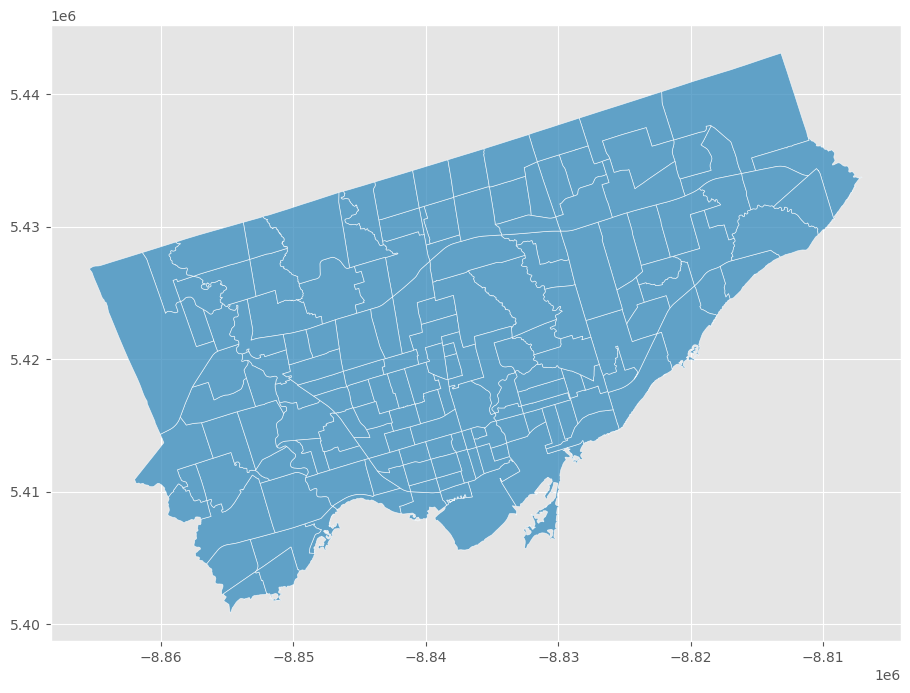

In [137]:
neighbourhoods_geodata.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

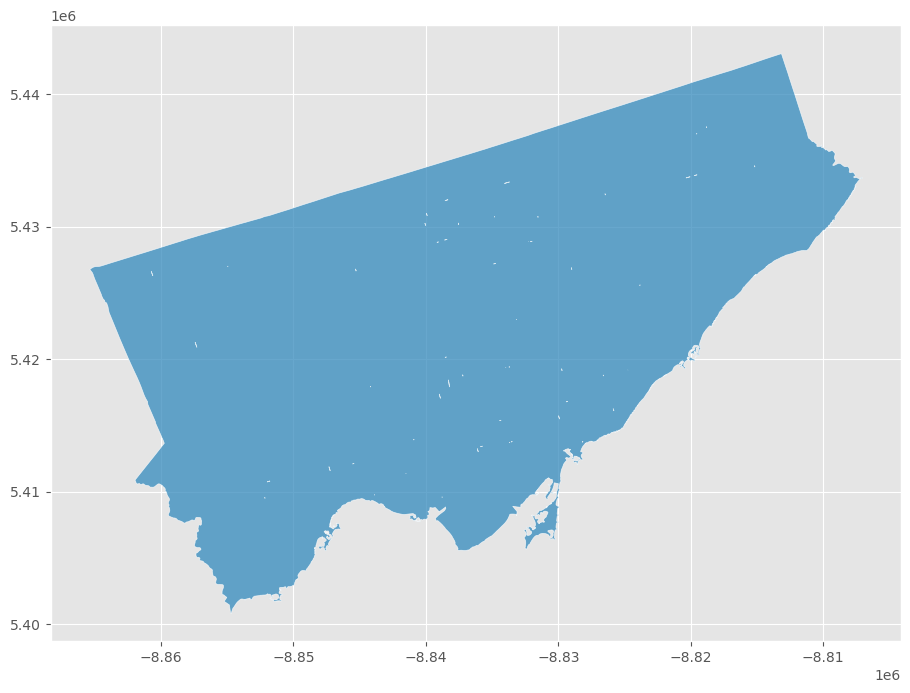

In [135]:
toronto.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

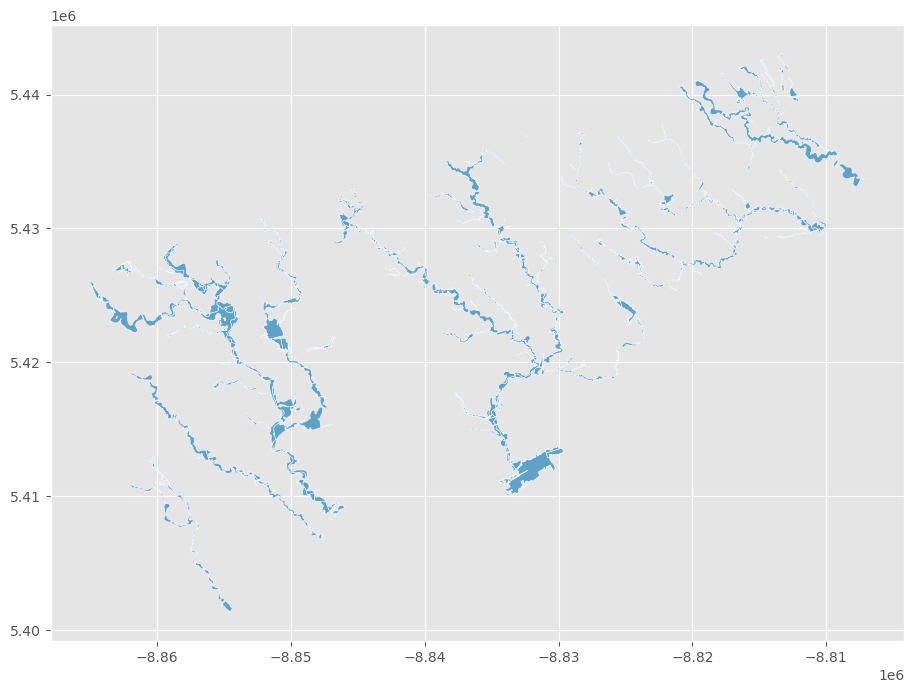

In [136]:
#### Create relevant flooplains by limiting to toroto
flood_plains = gpd.overlay(flood_plains,toronto , how='intersection')
flood_plains.plot(figsize=(15, 8), edgecolor='w', alpha=0.75);

In [123]:
# Create as single multiploygon for floodplain
flood_plains_single = flood_plains.geometry.unary_union
flood_plains_single_df = gpd.GeoDataFrame({'geometry': [flood_plains_single]}, crs=flood_plains.crs)
# Create area col
flood_plains_single_df['Area'] = flood_plains_single_df.geometry.area/(1000**2)
flood_plains_single_df

,geometry,Area
0,"MULTIPOLYGON (((-8855004.866 5402051.023, -885...",80.464674


### Let's determine percent overlap of flood plains to zones, by zone 

In [106]:
# Open zone_geodata
zones_geodata.head()

,Zone_type,geometry
_id,,
1,Utility and Transportation,"MULTIPOLYGON (((-8817582.931 5437211.157, -881..."
2,Open Space,"MULTIPOLYGON (((-8850203.447 5420635.486, -885..."
3,Residential,"MULTIPOLYGON (((-8824777.541 5434648.934, -882..."
4,Open Space,"MULTIPOLYGON (((-8857736.121 5422483.393, -885..."
5,Residential,"MULTIPOLYGON (((-8823408.202 5436387.536, -882..."


In [153]:
# Group by 'Zone_type' and aggregate the geometries using unary_union
aggregated_zones = zones_geodata.groupby('Zone_type')['geometry'].apply(lambda x: x.unary_union).reset_index()

# Calculate are in square km, because crs is EPSG 3857, standard area calc will be in m^2
aggregated_zones['Area'] = aggregated_zones.geometry.area/(1000**2)

# Now 'aggregated_zones' will contain the union of polygons for each 'Zone_type' with the total area
aggregated_zones

,Zone_type,geometry,Area
0,Commercial,"MULTIPOLYGON (((-8852773.849 5403144.195, -885...",41.385882
1,Industrial,"MULTIPOLYGON (((-8861524.877 5410974.607, -886...",108.560630
2,Institutional,"MULTIPOLYGON (((-8851448.077 5403344.869, -885...",6.305369
3,Open Space,"MULTIPOLYGON (((-8856043.008 5403941.536, -885...",202.377445
4,Residential,"MULTIPOLYGON (((-8856967.840 5407952.703, -885...",579.005011
5,Utility and Transportation,"MULTIPOLYGON (((-8855941.397 5406929.779, -885...",60.169092


In [151]:
aggregated_zones['Area'].sum()

997.8034290167461

In [154]:
# Let's create unzoned area which is everything that is in the Neighbourhood toronto map, NOT zoned
toronto_geometry = toronto.geometry.iloc[0]

# Get the area of Toronto's geometry in km^2
toronto_area = toronto['Area'].iloc[0] 

# get zoned area geometry
zoned_geometry = toronto_geometry.intersection(aggregated_zones.geometry.unary_union)

# calculate the area of the zoned area in square kilometers (km²)
zoned_area = zoned_geometry.area / (1000**2)

# Step 5: Calculate the Unzoned area as the difference between Toronto's total area and the zoned areas
unzoned_area = toronto_area - zoned_area

# Step 6: Create a new row for the Unzoned area
unzoneds = gpd.GeoDataFrame({
    'Zone_type': ['Unzoned'],
    'geometry': [toronto_geometry.difference(aggregated_zones.geometry.unary_union)],
    'Area': [unzoned_area]
}, crs=aggregated_zones.crs)

# Step 7: Append the Unzoned row to the aggregated_zones GeoDataFrame
aggregated_zones = pd.concat([aggregated_zones, unzoneds], ignore_index=True)
aggregated_zones

,Zone_type,geometry,Area
0,Commercial,"MULTIPOLYGON (((-8852773.849 5403144.195, -885...",41.385882
1,Industrial,"MULTIPOLYGON (((-8861524.877 5410974.607, -886...",108.560630
2,Institutional,"MULTIPOLYGON (((-8851448.077 5403344.869, -885...",6.305369
3,Open Space,"MULTIPOLYGON (((-8856043.008 5403941.536, -885...",202.377445
4,Residential,"MULTIPOLYGON (((-8856967.840 5407952.703, -885...",579.005011
5,Utility and Transportation,"MULTIPOLYGON (((-8855941.397 5406929.779, -885...",60.169092
6,Unzoned,"MULTIPOLYGON (((-8852251.134 5402228.219, -885...",234.265908


In [155]:
aggregated_zones['Area'].sum()

1232.0693367773881

In [156]:
# Step 1: Perform the intersection of each zone's geometry with the flood plain
aggregated_zones['flood_intersection'] = aggregated_zones.geometry.intersection(flood_plains_single_df.geometry.iloc[0])

# Step 2: Calculate the area of the intersection (in square units of the CRS)
aggregated_zones['flood_intersection_area'] = aggregated_zones['flood_intersection'].area /(1000**2)

# Step 3: Calculate the total area of the flood plain
flood_plain_area = flood_plains_single_df['Area'].iloc[0]

# Step 4: Calculate the proportion of each zone's intersection with the flood plain
aggregated_zones['Proportion_zone_flooded'] = aggregated_zones['flood_intersection_area'] / aggregated_zones['Area']

aggregated_zones['Proportion of flood that is Zone'] = aggregated_zones['flood_intersection_area'] / flood_plain_area

# Result
aggregated_zones

,Zone_type,geometry,Area,flood_intersection,flood_intersection_area,Proportion_zone_flooded,Proportion of flood that is Zone
0,Commercial,"MULTIPOLYGON (((-8852773.849 5403144.195, -885...",41.385882,"MULTIPOLYGON (((-8858452.803 5410024.436, -885...",0.637980,0.015415,0.007929
1,Industrial,"MULTIPOLYGON (((-8861524.877 5410974.607, -886...",108.560630,"MULTIPOLYGON (((-8859069.734 5416165.000, -885...",3.109431,0.028642,0.038643
2,Institutional,"MULTIPOLYGON (((-8851448.077 5403344.869, -885...",6.305369,"MULTIPOLYGON (((-8850726.224 5409617.761, -885...",0.054107,0.008581,0.000672
3,Open Space,"MULTIPOLYGON (((-8856043.008 5403941.536, -885...",202.377445,"MULTIPOLYGON (((-8855182.811 5402394.689, -885...",59.861855,0.295793,0.743952
4,Residential,"MULTIPOLYGON (((-8856967.840 5407952.703, -885...",579.005011,"MULTIPOLYGON (((-8856969.079 5407958.793, -885...",5.599832,0.009671,0.069594
5,Utility and Transportation,"MULTIPOLYGON (((-8855941.397 5406929.779, -885...",60.169092,"MULTIPOLYGON (((-8857440.236 5405871.783, -885...",2.854832,0.047447,0.035479
6,Unzoned,"MULTIPOLYGON (((-8852251.134 5402228.219, -885...",234.265908,GEOMETRYCOLLECTION (POLYGON ((-8855134.698 540...,8.349605,0.035642,0.103767


In [159]:
aggregated_zones['Proportion of flood that is Zone'].sum()

1.0000368822893742

In [188]:
# Write to CSV to use for future...
aggregated_zones.to_csv('Zones and Flooding.csv')

# Print confirmation comment
print("DataFrame has been written to 'Zones and Flooding.csv'")

DataFrame has been written to 'Zones and Flooding.csv'


### Let's determine percent overlap of flood plains to "Green space", by type 

In [127]:
# Step 1: Perform the intersection of each zone's geometry with the flood plain
aggregated_greenspace['flood_intersection'] = aggregated_greenspace.geometry.intersection(flood_plains_single_df.geometry.iloc[0])

# Step 2: Calculate the area of the intersection (in square units of the CRS)
aggregated_greenspace['flood_intersection_area'] = aggregated_greenspace['flood_intersection'].area /(1000**2)


# Step 4: Calculate the proportion of each zone's intersection with the flood plain
aggregated_greenspace['Proportion_zone_flooded'] = aggregated_greenspace['flood_intersection_area'] / aggregated_greenspace['Area']

aggregated_greenspace['Proportion of flood that is Zone'] = aggregated_greenspace['flood_intersection_area'] / flood_plain_area

# Result
aggregated_greenspace

,Area_type,geometry,Area,flood_intersection,flood_intersection_area,Proportion_zone_flooded,Proportion of flood that is Zone
0,Cemetery,"MULTIPOLYGON (((-8849738.999 5406369.433, -884...",9.464416,"MULTIPOLYGON (((-8853709.741 5418481.880, -885...",0.231870,0.024499,0.002882
1,Golf course,"MULTIPOLYGON (((-8857665.581 5408486.096, -885...",17.918173,"MULTIPOLYGON (((-8857556.858 5408365.192, -885...",7.453106,0.415952,0.092626
2,Greenspace,"MULTIPOLYGON (((-8856211.485 5404435.903, -885...",162.640948,"MULTIPOLYGON (((-8856182.194 5404405.172, -885...",44.983161,0.276580,0.559042
3,Other,"MULTIPOLYGON (((-8855139.808 5402243.758, -885...",24.294922,"MULTIPOLYGON (((-8855197.201 5402289.608, -885...",4.020835,0.165501,0.049970
4,Utilities and Transportation,"MULTIPOLYGON (((-8857116.113 5404857.742, -885...",17.902800,"MULTIPOLYGON (((-8857034.466 5404882.992, -885...",1.331650,0.074382,0.016550


In [129]:
print(str(1-aggregated_greenspace['Proportion of flood that is Zone'].sum()) + "% of flooded area is not considered by green space dataset")

0.2789305130292834% of flooded area is not considered by green space dataset


### Let's do the same exercise for neighbourhoods to see what neighbourhoods are the most flooded...

In [173]:
neighbourhoods_copy = neighbourhoods_geodata.reset_index()

# Get area in km^2
neighbourhoods_copy['Area'] = neighbourhoods_copy.geometry.area / (1000**2)

#make a copy in desired format
neighbourhoods_copy 

,Neighbourhood_name,geometry,Area
0,South Eglinton-Davisville,"MULTIPOLYGON (((-8837248.175 5418799.333, -883...",1.808050
1,North Toronto,"MULTIPOLYGON (((-8838482.219 5420200.361, -883...",0.769973
2,Dovercourt Village,"MULTIPOLYGON (((-8842565.029 5412998.632, -884...",2.874418
3,Junction-Wallace Emerson,"MULTIPOLYGON (((-8843075.634 5414155.146, -884...",4.251031
4,Yonge-Bay Corridor,"MULTIPOLYGON (((-8836990.902 5410663.098, -883...",2.138518
...,...,...,...
153,West Humber-Clairville,"MULTIPOLYGON (((-8859959.594 5424371.665, -885...",57.751616
154,Black Creek,"MULTIPOLYGON (((-8852030.826 5430533.185, -885...",6.627278
155,Pelmo Park-Humberlea,"MULTIPOLYGON (((-8853489.698 5424531.344, -885...",8.192345
156,Humbermede,"MULTIPOLYGON (((-8853030.557 5425949.442, -885...",8.478392


In [174]:
# Step 1: Perform the intersection of each zone's geometry with the flood plain
neighbourhoods_copy['flood_intersection'] = neighbourhoods_copy.geometry.intersection(flood_plains_single_df.geometry.iloc[0])

# Calculate the area of the intersection (in square units of the CRS)
neighbourhoods_copy['flood_intersection_area'] = neighbourhoods_copy['flood_intersection'].area /(1000**2)

# Get the total area of the flood plain
flood_plain_area = flood_plains_single_df['Area'].iloc[0]

# Calculate the proportion of each zone's intersection with the flood plain
neighbourhoods_copy['Proportion Neighbourhood flooded'] = neighbourhoods_copy['flood_intersection_area'] / neighbourhoods_copy['Area']

neighbourhoods_copy['Proportion of flood that is Neighbourhood'] = neighbourhoods_copy['flood_intersection_area'] / flood_plain_area

# Result

#Sort by most flooded neighbourhood
neighbourhoods_copy = neighbourhoods_copy.sort_values(by='Proportion Neighbourhood flooded', ascending=False)  # Use ascending=False for descending order
neighbourhoods_copy

,Neighbourhood_name,geometry,Area,flood_intersection,flood_intersection_area,Proportion Neighbourhood flooded,Proportion of flood that is Neighbourhood
149,Elms-Old Rexdale,"MULTIPOLYGON (((-8855105.833 5423993.698, -885...",5.616154,"MULTIPOLYGON (((-8855056.313 5423976.029, -885...",2.316251,0.412427,0.028786
76,Rockcliffe-Smythe,"MULTIPOLYGON (((-8847133.600 5416231.647, -884...",9.701005,"MULTIPOLYGON (((-8846966.482 5415345.387, -884...",3.176384,0.327428,0.039476
151,Thistletown-Beaumond Heights,"MULTIPOLYGON (((-8856830.229 5425869.333, -885...",6.402351,"MULTIPOLYGON (((-8856838.674 5425851.942, -885...",1.705209,0.266341,0.021192
85,South Riverdale,"MULTIPOLYGON (((-8830807.123 5412872.663, -883...",21.081810,"MULTIPOLYGON (((-8830801.148 5412858.641, -883...",4.780673,0.226768,0.059413
73,Lambton Baby Point,"MULTIPOLYGON (((-8849813.365 5413870.667, -884...",3.407414,"MULTIPOLYGON (((-8849078.114 5411043.271, -884...",0.672654,0.197409,0.008360
...,...,...,...,...,...,...,...
64,Corso Italia-Davenport,"MULTIPOLYGON (((-8843616.190 5416277.478, -884...",3.614704,POLYGON EMPTY,0.000000,0.000000,0.000000
63,Wychwood,"MULTIPOLYGON (((-8840784.831 5416471.481, -884...",3.217960,POLYGON EMPTY,0.000000,0.000000,0.000000
62,Annex,"MULTIPOLYGON (((-8840684.278 5413566.257, -884...",5.337192,POLYGON EMPTY,0.000000,0.000000,0.000000
61,Casa Loma,"MULTIPOLYGON (((-8838790.868 5416597.118, -883...",3.678384,POLYGON EMPTY,0.000000,0.000000,0.000000


In [176]:
#Check flood area is fully accounted for
neighbourhoods_copy['Proportion of flood that is Neighbourhood'].sum()

1.00000001505031

In [187]:
# Write to CSV to use for future...
neighbourhoods_copy.to_csv('Neighbourhoods and Flooding.csv')

# Print confirmation comment
print("DataFrame has been written to 'Neighbourhoods and Flooding.csv'")

DataFrame has been written to 'Neighbourhoods and Flooding.csv'


In [180]:
flood_plains_single_df

,geometry,Area
0,"MULTIPOLYGON (((-8855004.866 5402051.023, -885...",80.464674


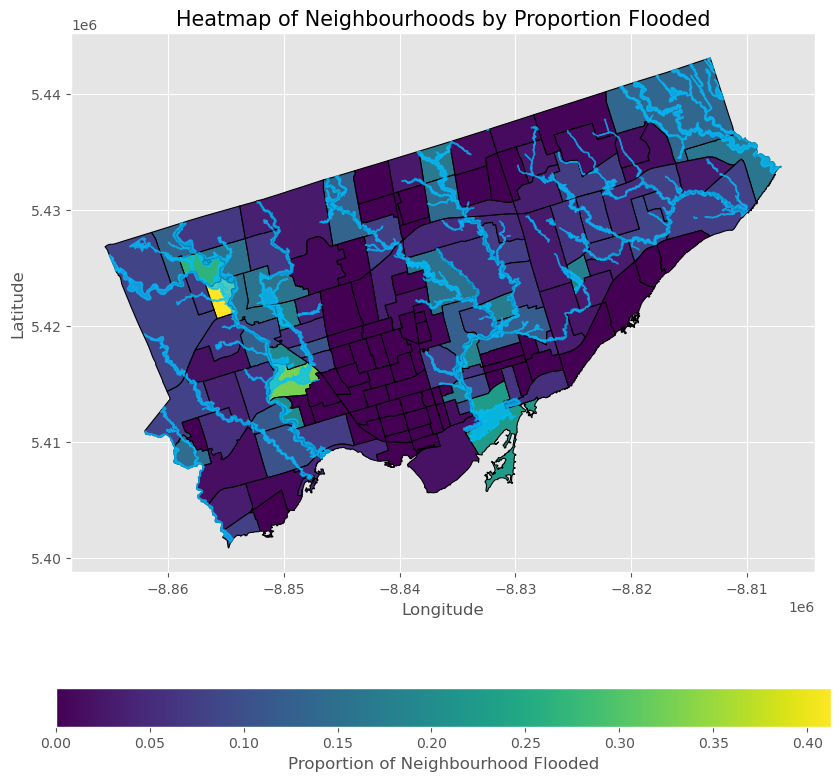

In [186]:
fig, ax = plt.subplots(figsize=(10, 10))  # Adjust figure size as needed
neighbourhoods_copy.plot(column='Proportion Neighbourhood flooded', 
                         cmap='viridis',  
                         linewidth=0.8, 
                         ax=ax, 
                         edgecolor='k',  # Adds a black border around each neighborhood
                         legend=True,  # Adds a legend for color mapping
                         legend_kwds={'label': "Proportion of Neighbourhood Flooded",
                                      'orientation': "horizontal"})

flood_plains_single_df.plot(ax=ax, color=(0/255, 191/255, 255/255), edgecolor=(0/255, 191/255, 255/255), linewidth=1, alpha=0.7)  # Customize appearance


# Add title and labels
ax.set_title("Heatmap of Neighbourhoods by Proportion Flooded", fontsize=15)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show plot
plt.show()